In [1]:
import keras

Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5103)
/home/joakim/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
path = "data/"
model_path = "model/second/"
batch_size=10

In [3]:
import utils; reload(utils)
from utils import *
import bcolz
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function

I'll begin by making a sample of our dataset, so we can iterate over solutions more quickly than otherwise.

Doing a full pass of the training-data with a 80/20 split on my GTX 970 takes around 6-8 minutes, which is too long to actually experiment.

In [4]:
%ls

cats_vs_dogs_redux_first.ipynb   data/     utils.py*  vgg16bn.py*  vgg16.py*
cats_vs_dogs_redux_second.ipynb  results/  utils.pyc  vgg16bn.pyc  vgg16.pyc


In [14]:
import os, sys
%cd data
DATA_HOME_DIR = os.getcwd()
print(DATA_HOME_DIR)

/home/joakim/projects/KaggleDogsCatsRedux/data
/home/joakim/projects/KaggleDogsCatsRedux/data


In [7]:
%cd DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/joakim/projects/KaggleDogsCatsRedux/data


In [30]:
from shutil import copyfile
def execute_on_random_jpgs(directory, method, num_files):
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(num_files): method(shuf[i], '{}/{}'.format(directory, shuf[i]))

In [31]:
%cd $DATA_HOME_DIR/train/
#commented out to make sure I don't execute this several times by mistake
#execute_on_random_jpgs('{}/{}'.format(DATA_HOME_DIR, 'valid'), os.rename, 2000)

/home/joakim/projects/KaggleDogsCatsRedux/data/train


In [32]:
%cd $DATA_HOME_DIR/train/
#execute_on_random_jpgs('{}/{}'.format(DATA_HOME_DIR, 'sample/train'), copyfile, 250)
#execute_on_random_jpgs('{}/{}'.format(DATA_HOME_DIR, 'sample/valid'), copyfile, 75)

/home/joakim/projects/KaggleDogsCatsRedux/data/train


In [36]:
def move_dogs_cats(directory):
    %cd $directory
    %mkdir cats
    %mkdir dogs
    %mv cat.*.jpg cats/
    %mv dog.*.jpg dogs/

In [37]:
move_dogs_cats(DATA_HOME_DIR+"/sample/train")
move_dogs_cats(DATA_HOME_DIR+"/sample/valid")
move_dogs_cats(DATA_HOME_DIR+"/valid")
move_dogs_cats(DATA_HOME_DIR+"/train")

/home/joakim/projects/KaggleDogsCatsRedux/data/sample/train
mkdir: cannot create directory ‘cats’: File exists
mkdir: cannot create directory ‘dogs’: File exists
mv: cannot stat 'cat.*.jpg': No such file or directory
mv: cannot stat 'dog.*.jpg': No such file or directory
/home/joakim/projects/KaggleDogsCatsRedux/data/sample/valid
/home/joakim/projects/KaggleDogsCatsRedux/data/valid
/home/joakim/projects/KaggleDogsCatsRedux/data/train


In [38]:
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/joakim/projects/KaggleDogsCatsRedux/data/test


In [44]:
%cd ../..

/home/joakim/projects/KaggleDogsCatsRedux


In [4]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [7]:
imgs,labels = next(batches)

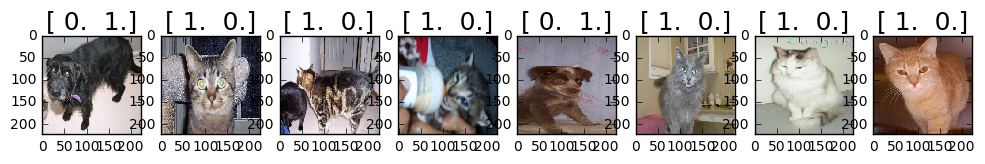

In [8]:
plots(imgs, titles=labels)

In [53]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN()
vgg.finetune(batches)
model = vgg.model

/home/joakim/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [49]:
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)

In [50]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [51]:
gen = image.ImageDataGenerator()

In [54]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model.fit_generator(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 250 samples, validate on 75 samples
Epoch 1/3
250/250 [==============================] - 5s - loss: 0.7002 - acc: 0.8440 - val_loss: 0.3144 - val_acc: 0.9067 20/250 [=>............................] - ETA: 4s - loss: 1.8081 - acc: 0.6500

In [56]:
model.save_weights(path+'results/ft1.h5')

In [57]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [58]:
model.load_weights(path+'results/ft1.h5')

In [59]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [61]:
conv_model = Sequential(conv_layers)
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
                                                                   lambda_2[0][0]                   
                                                                   lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
                                                                   zeropadding2d_14[1][0]  

In [62]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [63]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [64]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [65]:
conv_val_feat.shape

(75, 512, 14, 14)

In [84]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(2, activation='softmax')
    ]

In [85]:
p = 0.4

In [89]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 250 samples, validate on 75 samples
Epoch 1/3
250/250 [==============================] - 0s - loss: 0.1059 - acc: 0.9640 - val_loss: 0.4468 - val_acc: 0.9333 20/250 [=>............................] - ETA: 0s - loss: 0.3246 - acc: 0.9000

In [93]:
bn_model.save_weights(path+'models/conv_512_6.h5')

In [94]:
bn_model.evaluate(conv_val_feat, val_labels)

32/75 [===========>..................] - ETA: 0s64/75 [========================>.....] - ETA: 0s

[0.44784607768058776, 0.89333333730697628]

In [95]:
bn_model.load_weights(path+'models/conv_512_6.h5')

In [96]:
import PIL
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [97]:
import collections
collections.Counter(sizes)

Counter({(50, 38): 1,
         (85, 149): 1,
         (96, 70): 1,
         (115, 103): 1,
         (133, 199): 1,
         (138, 200): 1,
         (139, 128): 1,
         (139, 137): 1,
         (141, 128): 1,
         (153, 251): 1,
         (159, 288): 1,
         (165, 121): 1,
         (195, 384): 1,
         (196, 239): 1,
         (199, 179): 1,
         (199, 200): 1,
         (199, 255): 1,
         (199, 272): 1,
         (200, 149): 1,
         (206, 239): 1,
         (210, 500): 1,
         (215, 288): 1,
         (221, 222): 1,
         (224, 300): 1,
         (224, 447): 1,
         (229, 500): 1,
         (233, 175): 1,
         (239, 228): 1,
         (246, 500): 1,
         (248, 270): 1,
         (251, 221): 1,
         (257, 288): 1,
         (257, 359): 1,
         (260, 171): 1,
         (271, 324): 1,
         (276, 374): 1,
         (280, 287): 1,
         (280, 500): 1,
         (285, 322): 1,
         (289, 499): 1,
         (299, 225): 1,
         (299, 231): 

We are indeed losing valuable information by downscaling to 224x224 like VGG expects us to have because of the dense layers at the bottom.

We'll try a completely CNN approach like in the fast.ai course.

In [4]:
size = (450,450) # guesstimated from earlier output.
batches = get_batches(path+'train', batch_size=1, shuffle=False, target_size=size)
val_batches = get_batches(path+'valid', batch_size=1, shuffle=False, target_size=size)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [5]:
vgg300 = Vgg16BN(size).model
vgg300.pop()
for layer in vgg300.layers: layer.trainable=False
vgg300.input_shape, vgg300.output_shape
vgg300.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

/home/joakim/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 450, 450)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [29]:
vgg300.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_input_3 (InputLayer)      (None, 3, 280, 280)   0                                            
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 3, 280, 280)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 282, 282)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 280, 280)  1792        zeropadding2d_27[0][0]           
___________________________________________________________________________________________

In [6]:
def json_encode_numpyarr(nparray):
    python_list_np = nparray.tolist()
    json_string = json.dumps(python_list_np, separators=(',', ':'), sort_keys=True, indent=4)
    return zlib.compress(json_string)
    
def json_decode_numpyarr(encoded_data):
    decoded_data = zlib.decompress(encoded_data)
    b_new = json.loads(decoded_data)
    return np.array(b_new)

In [7]:
import cPickle as pickle
import zlib
import json

def save_generated_features(batches, filename):
    count = 0
    prev_percent = 0
    num_samples = batches.nb_sample
    with open('{}/{}.pkl'.format("data/results", filename), 'ab') as pickle_file:  # Note: `ab` appends the data
        for img, label in batches:
            count += 1
            if int((count/num_samples)*100) >= prev_percent + 10:
                prev_percent = int((count/num_samples)*100)
                print("Pickling is {} percent done.".format(prev_percent))
            features = vgg300.predict(img)
            obj_to_pickle = json_encode_numpyarr(features), label
            pickle.dump(obj_to_pickle, pickle_file, pickle.HIGHEST_PROTOCOL)
            if count == num_samples:
                break

In [9]:
def load_generated_features(file_path, batch_size):
    try:
        with open(file_path, 'rb') as pickle_file:
            while True:
                compressed_features, label = pickle.load(pickle_file)
                decompressed_features = json_decode_numpyarr(compressed_features)
                yield (decompressed_features, label)
    except EOFError:
        pass

In [33]:
def load_generated_features_no_label(file_path, batch_size):
    try:
        with open(file_path, 'rb') as pickle_file:
            while True:
                compressed_features, _ = pickle.load(pickle_file)
                decompressed_features = json_decode_numpyarr(compressed_features)
                yield decompressed_features
    except EOFError:
        pass

In [ ]:
save_generated_features(val_batches, "val_batches")

In [22]:
save_generated_features(batches, "trn_batches")

Pickling is 10 percent done.
Pickling is 20 percent done.
Pickling is 30 percent done.
Pickling is 40 percent done.
Pickling is 50 percent done.
Pickling is 60 percent done.
Pickling is 70 percent done.
Pickling is 80 percent done.
Pickling is 90 percent done.
Pickling is 100 percent done.


In [27]:
test_batches = get_batches(path+'test', batch_size=1, shuffle=False, target_size=size)

Found 12500 images belonging to 1 classes.


In [28]:
save_generated_features(test_batches, "test_batches")

Pickling is 10 percent done.
Pickling is 20 percent done.
Pickling is 30 percent done.
Pickling is 40 percent done.
Pickling is 50 percent done.
Pickling is 60 percent done.
Pickling is 70 percent done.
Pickling is 80 percent done.
Pickling is 90 percent done.
Pickling is 100 percent done.


Using a fully convolutional net might not work so well, since the dogs and cats are usually a larger part of the image. But I want to try it :)

In [20]:
conv_layers,_ = split_at(vgg300, Convolution2D)

In [21]:
nf=128; p=0. #No dropout in our FCN

In [22]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(2,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [23]:
lrg_model = Sequential(get_lrg_layers())

In [43]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 512, 28, 28)   2048        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 128, 28, 28)   589952      batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 128, 28, 28)   512         convolution2d_40[0][0]           
____________________________________________________________________________________________________
maxpooling2d_16 (MaxPooling2D)   (None, 128, 14, 14)   0           batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [24]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
validation_generator = load_generated_features(path+"results/val_batches.pkl", batch_size)
train_generator = load_generated_features(path+"results/trn_batches.pkl", batch_size)
lrg_model.fit_generator(train_generator, samples_per_epoch=23000, nb_epoch=1,
                       validation_data=validation_generator, nb_val_samples=2000)

Epoch 1/1
19883/23000 [========================>.....] - ETA: 292s - loss: 0.0033 - acc: 0.9997 9999

In [15]:
lrg_model.save_weights(path+'models/fully_conv_450.h5')

In [25]:
lrg_model.load_weights(path+'models/fully_conv_450.h5')

In [34]:
preds = lrg_model.predict_generator(load_generated_features_no_label(path+"results/test_batches.pkl", batch_size), 12500)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/joakim/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/joakim/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/joakim/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 409, in data_generator_task
    generator_output = next(generator)
StopIteration



In [36]:
print(len(preds))

12500


In [37]:
isdog = preds[:,1]

In [38]:
isdog = isdog.clip(min=0.05, max=0.95)

In [40]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in test_filenames])

In [41]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  4.0680e+03,   9.5000e-01],
       [  5.9930e+03,   9.5000e-01],
       [  3.6040e+03,   9.5000e-01],
       [  7.2650e+03,   9.5000e-01],
       [  5.8700e+03,   9.5000e-01]])

In [43]:
submission_file_name = path + 'results/submission2.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')